In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   #(xxxx is your specific GPU ID)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import math
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
print(torch.__version__)

1.10.1+cu102


In [5]:
# comparing to vit, here I changed kernel size, stride size and the size of fc1_1, due to the different outputsize of pre-train

In [6]:
###################### model 2 (keyword)###################### 

class keyword_net(nn.Module):
    def __init__(self):
        super(keyword_net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)            
        self.cvd = nn.Conv2d(in_channels=7, out_channels=3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)) 
        self.fc1_1 = nn.Linear(71910,128) 
        self.fc1_2 = nn.Linear(128,256) 
        self.keyword_output_1 = nn.Linear(256,11) 
        self.fc2_1 = nn.Linear(71910,512) # Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,name='fc2_1')
        self.fc2_2 = nn.Linear(512,512) # tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,name='fc2_2')
        self.getalphafromy2 = nn.Linear(512,512)
        self.fc2_3 = nn.Linear(1024,512)
        self.keyword_output_2 = nn.Linear(512,23) # tf.keras.layers.Dense(10, activation='softmax',name='command_output')


    def forward(self, x):
   
        # convert 512*7*7 to 512*49
#         print("before:" , x.shape)
        x =  x.reshape(x.size(0), x.size(1), x.size(2), -1)
#         print("after:" , x.shape)
        x = self.cvd(x)
        x = x.view(x.size(0), -1) 
        
        y1 = self.fc1_1(x)
        y1 = self.relu(y1)
        y1 = self.fc1_2(y1)
        y1 = self.sigmoid(y1) 
        y1 = self.keyword_output_1(y1)
        y1 = self.softmax(y1)
        
        y2 = self.fc2_1(x)
        y2 = self.relu(y2)
        y2 = self.fc2_2(y2)
        y2 = self.sigmoid(y2) 
        y2 = self.keyword_output_2(y2)
        y2 = self.softmax(y2)
        
        return y1,y2

In [7]:
class CombinedModel(nn.Module):
    def __init__(self, PRETRAIN_MODEL,keyword_net):
        super(CombinedModel, self).__init__()
        self.pretrain_model = PRETRAIN_MODEL
        self.keyword_net = keyword_net
        
    def forward(self, x):
#         print(x.shape)
#         print(x[:][0].shape)
        x1 = self.pretrain_model(x[:,0,:,:])
        x1 = torch.unsqueeze(x1, dim=1)
#         print(x1.shape)
        x2 = self.pretrain_model(x[:,1,:,:])
        x2 = torch.unsqueeze(x2, dim=1)
        x3 = self.pretrain_model(x[:,2,:,:])
        x3 = torch.unsqueeze(x3, dim=1)
        x4 = self.pretrain_model(x[:,3,:,:])
        x4 = torch.unsqueeze(x4, dim=1)        
        x5 = self.pretrain_model(x[:,4,:,:])
        x5 = torch.unsqueeze(x5, dim=1)        
        x6 = self.pretrain_model(x[:,5,:,:])
        x6 = torch.unsqueeze(x6, dim=1)        
        x7 = self.pretrain_model(x[:,6,:,:]) 
        x7 = torch.unsqueeze(x7, dim=1)      
                
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7), axis=1)
#         print(x.shape)
        y1,y2= self.keyword_net(x)
        return y1,y2
        

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_number = 11
train_image = 7 #10:20%, 20: 40%, 30:60%
val_image = 10
test_image = 10
# load_Data = ImageDataGenerator(preprocessing_function=preprocess_input)
load_Data = ImageDataGenerator(rescale=1./255)
Train_X = []
Train_Y_command = []
Train_Y_subject = []
Val_X = []
Val_Y_command = []
Val_Y_subject = []
Test_X = []
Test_Y_command = []
Test_Y_subject = []

for chan in range(1,8):
    chanl = str(chan)
    train_generator = load_Data.flow_from_directory("sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Train"%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = train_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    All_command_class = tf.keras.utils.to_categorical(train_generator.classes, num_classes=23)
    All_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    All_Inputs = [next(train_generator)[0][0] for _ in range(len(train_generator))]
    All_Inputs = np.array(All_Inputs)
    # count the training data number to select the training size
    count = []
    c = 0
    word = train_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and train_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = train_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)

    select_indexs_train = np.array(count) <= train_image
    train_participant_no =  participant_no[select_indexs_train]  
    Train_Inputs = All_Inputs[select_indexs_train]
    Train_command_class = All_command_class[select_indexs_train]
    Train_participant_class = All_participant_class[select_indexs_train]


    val_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Val'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                   shuffle=False)
    Val_command_class = tf.keras.utils.to_categorical( val_generator.classes, num_classes=23)
    image_names = val_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Val_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Val_Inputs = [next(val_generator)[0][0] for _ in range(len(val_generator))]
    Val_Inputs = np.array(Val_Inputs)
    count = []
    c = 0
    word = val_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and val_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = val_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_val = np.array(count) <= val_image
    val_participant_no =  participant_no[select_indexs_val]  
    Val_Inputs = Val_Inputs[select_indexs_val]
    Val_command_class = Val_command_class[select_indexs_val]
    Val_participant_class = Val_participant_class[select_indexs_val]

    test_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Test'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = test_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Test_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Test_command_class = tf.keras.utils.to_categorical(test_generator.classes, num_classes=23)
    Test_Inputs = [next(test_generator)[0][0] for _ in range(len(test_generator))]
    Test_Inputs = np.array(Test_Inputs)

    count = []
    c = 0
    word = test_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and test_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = test_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_test = np.array(count) <= test_image
    test_participant_no =  participant_no[select_indexs_test]  
    Test_Inputs = Test_Inputs[select_indexs_test]
    Test_command_class = Test_command_class[select_indexs_test]
    Test_participant_class = Test_participant_class[select_indexs_test]

    Train_X.append(Train_Inputs.transpose(0,3,1,2))
    Val_X.append(Val_Inputs.transpose(0,3,1,2))
    Test_X.append(Test_Inputs.transpose(0,3,1,2))
    
    
Train_Y_command = Train_command_class
Train_Y_subject = Train_participant_class
Val_Y_command = Val_command_class
Val_Y_subject = Val_participant_class
Test_Y_command = Test_command_class
Test_Y_subject = Test_participant_class

Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.


In [11]:
del val_generator,train_generator,test_generator

In [12]:
Train_X[0].shape,Val_X[0].shape,Test_X[0].shape

((1771, 3, 224, 224), (2530, 3, 224, 224), (2530, 3, 224, 224))

In [13]:
Train_Inputs = torch.from_numpy(np.array(Train_X))
Val_Inputs = torch.from_numpy(np.array(Val_X))
Test_Inputs = torch.from_numpy(np.array(Test_X))

In [14]:
Train_Inputs[0][0].shape

torch.Size([3, 224, 224])

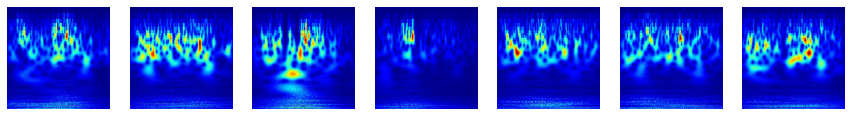

In [15]:
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(Train_Inputs[i][0].permute(1, 2, 0))
    plt.axis("off")
plt.show()
plt.close()

In [ ]:

y_test_sub = torch.from_numpy(Test_participant_class).to(device)
y_test_comd = torch.from_numpy(Test_command_class).to(device)

In [17]:
batch = 32
dataset = TensorDataset(Train_Inputs.permute(1,0,2,3,4), torch.from_numpy(Train_participant_class), torch.from_numpy(Train_command_class))
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

val_dataset = TensorDataset(Val_Inputs.permute(1,0,2,3,4), torch.from_numpy(Val_participant_class), torch.from_numpy(Val_command_class))
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

# freeze resnet 

In [18]:
unfreeze_bool = False
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 
    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_com = [] 
    total_losses = []
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_in_run = 0
    patience = 0
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
        t_acc_comd = []   
        t_acc_sub = []   
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        losses_sub_batch=[]
        losses_com_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_com_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val command accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
            best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            print("Run: ", run+1, ", and its best ",best_in_run)
            break    
    stop = timeit.default_timer()
    run_time = stop - start
    del model
    torch.cuda.empty_cache()
    # testing phase
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    pred_y_sub = []
    pred_y_comd = []
    best_model.to(device)
    best_model.eval() 
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,12):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
        acc_on_subjects.append(comd_acc_s.item()) 

    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
    print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

    # # Load the state dictionary into the new model
#     del best_model
    torch.cuda.empty_cache()

best_index = (Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------
Epoch 1 :
loss: 5.221870422363281 , subject train accuracy: 0.5128855524318559 , command train accuracy: 0.06412337667175702 , val subject accuracy: 0.7047430830039526 , val command accuracy: 0.13162055335968378
Epoch 2 :
loss: 4.994911193847656 , subject train accuracy: 0.7372666405779975 , command train accuracy: 0.21139407477208547 , val subject accuracy: 0.7711462450592885 , val command accuracy: 0.19446640316205532
Epoch 3 :
loss: 4.472083568572998 , subject train accuracy: 0.9213169642857143 , command train accuracy: 0.3836241886019707 , val subject accuracy: 0.9498023715415019 , val command accuracy: 0.2841897233201581
Epoch 4 :
loss: 4.420973777770996 , subject train accuracy: 0.9933035714285714 , command train accuracy: 0.5561079547873565 , val subject accuracy: 0.9711462450592885 , val command accuracy: 0.31541501976284586
Epoch 5 :
loss: 4.1105570793151855 , subject train accuracy: 0.9994419642857143 , command train accuracy: 0.6681209

loss: 5.371766090393066 , subject train accuracy: 0.4634232957448278 , command train accuracy: 0.07700892857142858 , val subject accuracy: 0.6675889328063241 , val command accuracy: 0.1549407114624506
Epoch 2 :
loss: 5.113561630249023 , subject train accuracy: 0.8253855524318559 , command train accuracy: 0.2554788962006569 , val subject accuracy: 0.8932806324110671 , val command accuracy: 0.250197628458498
Epoch 3 :
loss: 4.6630964279174805 , subject train accuracy: 0.9676339285714286 , command train accuracy: 0.4529220781155995 , val subject accuracy: 0.9691699604743083 , val command accuracy: 0.324901185770751
Epoch 4 :
loss: 4.209001541137695 , subject train accuracy: 0.9972098214285714 , command train accuracy: 0.6278916405779975 , val subject accuracy: 0.9782608695652174 , val command accuracy: 0.38458498023715415
Epoch 5 :
loss: 4.186277866363525 , subject train accuracy: 1.0 , command train accuracy: 0.7317877433129719 , val subject accuracy: 0.9790513833992095 , val command acc

loss: 3.7525229454040527 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9806324110671937 , val command accuracy: 0.47944664031620554
Epoch 46 :
loss: 3.7524166107177734 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9806324110671937 , val command accuracy: 0.4806324110671937
Epoch 47 :
loss: 3.7523984909057617 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9802371541501976 , val command accuracy: 0.4798418972332016
Run:  2 , and its best  1.4620553359683794

Run  2 Subject Accuracy 0.9841897233201581 command Accuracy is : 0.4505928853754941 Sub_1: 0.508695652173913 Sub_2: 0.5869565217391305 Sub_3: 0.4391304347826087 Sub_4: 0.41739130434782606 Sub_5: 0.40869565217391307 Sub_6: 0.47391304347826085 Sub_7: 0.6217391304347826 Sub_8: 0.45217391304347826 Sub_9: 0.36086956521739133 Sub_10: 0.3217391304347826 Sub_11: 0.3652173913043478
3 run: 
-------------------------------
Epoc

loss: 4.3194661140441895 , subject train accuracy: 0.91015625 , command train accuracy: 0.6481838476444993 , val subject accuracy: 0.8988142292490119 , val command accuracy: 0.34347826086956523
Epoch 8 :
loss: 4.383089542388916 , subject train accuracy: 0.9163453738604274 , command train accuracy: 0.6961241886019707 , val subject accuracy: 0.932806324110672 , val command accuracy: 0.29367588932806327
Epoch 9 :
loss: 3.987517833709717 , subject train accuracy: 0.9955357142857143 , command train accuracy: 0.751775569149426 , val subject accuracy: 0.9802371541501976 , val command accuracy: 0.32964426877470354
Epoch 10 :
loss: 4.067741394042969 , subject train accuracy: 0.9994419642857143 , command train accuracy: 0.7819602276597705 , val subject accuracy: 0.9826086956521739 , val command accuracy: 0.3565217391304348
Epoch 11 :
loss: 3.9751265048980713 , subject train accuracy: 1.0 , command train accuracy: 0.8003246762922832 , val subject accuracy: 0.9845849802371541 , val command accurac

loss: 3.7521188259124756 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9818181818181818 , val command accuracy: 0.46047430830039526
Epoch 53 :
loss: 3.752103805541992 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9818181818181818 , val command accuracy: 0.46126482213438735
Epoch 54 :
loss: 3.7519946098327637 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9818181818181818 , val command accuracy: 0.4600790513833992
Epoch 55 :
loss: 3.752021312713623 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9818181818181818 , val command accuracy: 0.4608695652173913
Epoch 56 :
loss: 3.7519690990448 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9818181818181818 , val command accuracy: 0.4608695652173913
Epoch 57 :
loss: 3.751904010772705 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val sub

loss: 3.7585625648498535 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9857707509881423 , val command accuracy: 0.458102766798419
Epoch 22 :
loss: 3.7578186988830566 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9857707509881423 , val command accuracy: 0.45691699604743086
Epoch 23 :
loss: 3.7574992179870605 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9857707509881423 , val command accuracy: 0.46047430830039526
Epoch 24 :
loss: 3.7571306228637695 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9853754940711462 , val command accuracy: 0.46403162055335967
Epoch 25 :
loss: 3.7564797401428223 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9857707509881423 , val command accuracy: 0.46284584980237153
Epoch 26 :
loss: 3.756227493286133 , subject train accuracy: 1.0 , command train accuracy: 1.0 , v

In [ ]:
PATH = "Final_model/sCPD_tiny_group_Featurefuse_freeze_0414"
torch.save(MODEL_LIST[(Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [20]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.462055,1.0,0.500000,0.360870,0.378261,0.569565,0.421739,0.395652,0.408696,0.486957,0.600000,0.495652,0.465217,0.979842,534.450090
1,0.450593,2.0,0.508696,0.321739,0.365217,0.586957,0.439130,0.417391,0.408696,0.473913,0.621739,0.452174,0.360870,0.984190,600.993599
2,0.467589,3.0,0.486957,0.395652,0.386957,0.556522,0.426087,0.460870,0.421739,0.491304,0.630435,0.486957,0.400000,0.983399,386.703709
3,0.452569,4.0,0.500000,0.343478,0.382609,0.573913,0.386957,0.465217,0.386957,0.473913,0.582609,0.473913,0.408696,0.981818,931.891467
4,0.467984,5.0,0.495652,0.395652,0.352174,0.586957,0.430435,0.434783,0.469565,0.478261,0.634783,0.465217,0.404348,0.982609,622.806183


In [21]:
Perfomance.describe()

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.460158,3.000000,0.498261,0.363478,0.373043,0.574783,0.420870,0.434783,0.419130,0.480870,0.613913,0.474783,0.407826,0.982372,615.369009
std,0.008203,1.581139,0.007898,0.032478,0.014222,0.012824,0.020019,0.029328,0.030836,0.007898,0.022041,0.017227,0.037326,0.001668,199.552074
min,0.450593,1.000000,0.486957,0.321739,0.352174,0.556522,0.386957,0.395652,0.386957,0.473913,0.582609,0.452174,0.360870,0.979842,386.703709
25%,0.452569,2.000000,0.495652,0.343478,0.365217,0.569565,0.421739,0.417391,0.408696,0.473913,0.600000,0.465217,0.400000,0.981818,534.450090
50%,0.462055,3.000000,0.500000,0.360870,0.378261,0.573913,0.426087,0.434783,0.408696,0.478261,0.621739,0.473913,0.404348,0.982609,600.993599
75%,0.467589,4.000000,0.500000,0.395652,0.382609,0.586957,0.430435,0.460870,0.421739,0.486957,0.630435,0.486957,0.408696,0.983399,622.806183
max,0.467984,5.000000,0.508696,0.395652,0.386957,0.586957,0.439130,0.465217,0.469565,0.491304,0.634783,0.495652,0.465217,0.984190,931.891467


In [22]:
se_command = Perfomance['Command Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.003668444158157191, 0.0007457692594511106, 0.024789555740981087)

In [23]:
pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.983399209486166
Test Command Accuracy: 0.46758893280632413


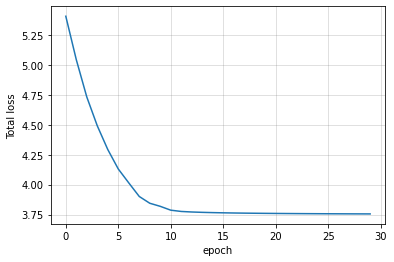

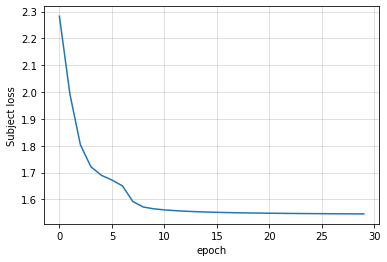

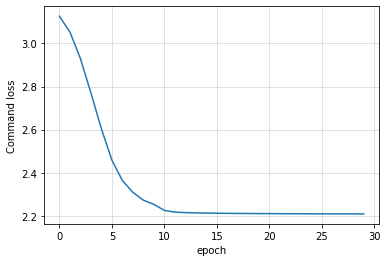

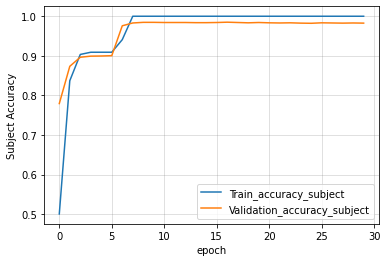

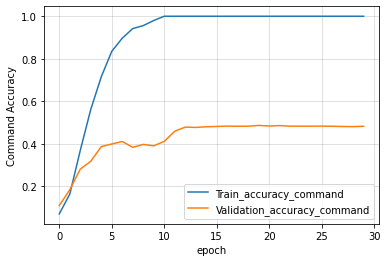

In [24]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['comd'])
plt.ylabel('Command loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
plt.ylabel('Command Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

In [25]:
for s in range(1,12):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 0.487
Subject # 2 : test Command Accuracy: 0.5565
Subject # 3 : test Command Accuracy: 0.4261
Subject # 4 : test Command Accuracy: 0.4609
Subject # 5 : test Command Accuracy: 0.4217
Subject # 6 : test Command Accuracy: 0.4913
Subject # 7 : test Command Accuracy: 0.6304
Subject # 8 : test Command Accuracy: 0.487
Subject # 9 : test Command Accuracy: 0.4
Subject # 10 : test Command Accuracy: 0.3957
Subject # 11 : test Command Accuracy: 0.387


In [26]:
Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_7Image_freeze_0414.csv",index=False)

# unfreeze all

In [27]:
del best_model


In [28]:
unfreeze_bool = True
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 
    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_com = [] 
    total_losses = []
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_in_run = 0
    patience = 0
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
        t_acc_comd = []   
        t_acc_sub = []   
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        losses_sub_batch=[]
        losses_com_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_com_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val command accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
            best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            print("Run: ", run+1, ", and its best ",best_in_run)
            break    
    stop = timeit.default_timer()
    run_time = stop - start
    del model
    torch.cuda.empty_cache()
    # testing phase
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    pred_y_sub = []
    pred_y_comd = []
    best_model.to(device)
    best_model.eval() 
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,12):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
        acc_on_subjects.append(comd_acc_s.item()) 

    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
    print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

    # # Load the state dictionary into the new model
#     del best_model
    torch.cuda.empty_cache()

best_index = (Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------
Epoch 1 :
loss: 5.262568950653076 , subject train accuracy: 0.36175933480262756 , command train accuracy: 0.0651379871581282 , val subject accuracy: 0.6758893280632411 , val command accuracy: 0.07786561264822134
Epoch 2 :
loss: 5.0206217765808105 , subject train accuracy: 0.7880986205169133 , command train accuracy: 0.1042004871581282 , val subject accuracy: 0.824505928853755 , val command accuracy: 0.12529644268774703
Epoch 3 :
loss: 4.929924964904785 , subject train accuracy: 0.8817471595747131 , command train accuracy: 0.1489448052431856 , val subject accuracy: 0.9055335968379447 , val command accuracy: 0.16521739130434782
Epoch 4 :
loss: 4.851650714874268 , subject train accuracy: 0.9465807633740562 , command train accuracy: 0.19576907477208547 , val subject accuracy: 0.9924901185770751 , val command accuracy: 0.22094861660079052
Epoch 5 :
loss: 4.455724716186523 , subject train accuracy: 0.9966517857142857 , command train accuracy: 0.2575588

loss: 3.7547049522399902 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.8944664031620554
Epoch 44 :
loss: 3.753622531890869 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.8944664031620554
Epoch 45 :
loss: 3.7536606788635254 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.8948616600790514
Epoch 46 :
loss: 3.7534022331237793 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8948616600790514
Epoch 47 :
loss: 3.753261089324951 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.8948616600790514
Epoch 48 :
loss: 3.753227710723877 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val su

Epoch 1 :
loss: 5.008769512176514 , subject train accuracy: 0.6177455357142857 , command train accuracy: 0.08816964285714286 , val subject accuracy: 0.7869565217391304 , val command accuracy: 0.14308300395256918
Epoch 2 :
loss: 4.6961188316345215 , subject train accuracy: 0.8800730524318559 , command train accuracy: 0.20119724050164223 , val subject accuracy: 0.9023715415019763 , val command accuracy: 0.24387351778656127
Epoch 3 :
loss: 4.584756851196289 , subject train accuracy: 0.9057934262922832 , command train accuracy: 0.3183340100305421 , val subject accuracy: 0.9106719367588932 , val command accuracy: 0.3569169960474308
Epoch 4 :
loss: 4.435649394989014 , subject train accuracy: 0.9564732142857143 , command train accuracy: 0.4533279218844005 , val subject accuracy: 0.9905138339920949 , val command accuracy: 0.4505928853754941
Epoch 5 :
loss: 4.299158096313477 , subject train accuracy: 1.0 , command train accuracy: 0.5253652600305421 , val subject accuracy: 0.9952569169960475 , v

loss: 3.753204822540283 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8936758893280632
Epoch 45 :
loss: 3.753331184387207 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8932806324110671
Epoch 46 :
loss: 3.7529876232147217 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8928853754940711
Epoch 47 :
loss: 3.752880573272705 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892490118577075
Epoch 48 :
loss: 3.7527379989624023 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892094861660079
Epoch 49 :
loss: 3.752588987350464 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject ac

loss: 3.7559516429901123 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8636363636363636
Epoch 32 :
loss: 3.75632643699646 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8644268774703557
Epoch 33 :
loss: 3.755117654800415 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8648221343873518
Epoch 34 :
loss: 3.754854202270508 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.866798418972332
Epoch 35 :
loss: 3.755197048187256 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.867193675889328
Epoch 36 :
loss: 3.7546401023864746 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

loss: 3.7551088333129883 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8600790513833992
Epoch 36 :
loss: 3.7548890113830566 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8600790513833992
Epoch 37 :
loss: 3.754646062850952 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8616600790513834
Epoch 38 :
loss: 3.7544212341308594 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8616600790513834
Epoch 39 :
loss: 3.754509925842285 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8620553359683795
Epoch 40 :
loss: 3.754658222

loss: 3.751502513885498 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8928853754940711
Epoch 79 :
loss: 3.7514564990997314 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8928853754940711
Epoch 80 :
loss: 3.751354694366455 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8928853754940711
Epoch 81 :
loss: 3.751351833343506 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8932806324110671
Epoch 82 :
loss: 3.751354932785034 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8928853754940711
Epoch 83 :
loss: 3.7512965202331543 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val sub

loss: 3.8730216026306152 , subject train accuracy: 1.0 , command train accuracy: 0.9386668024318559 , val subject accuracy: 0.9952569169960475 , val command accuracy: 0.7553359683794466
Epoch 23 :
loss: 3.867827892303467 , subject train accuracy: 1.0 , command train accuracy: 0.9520596595747131 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.799209486166008
Epoch 24 :
loss: 3.7628908157348633 , subject train accuracy: 1.0 , command train accuracy: 0.9553571428571429 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8371541501976285
Epoch 25 :
loss: 3.838655471801758 , subject train accuracy: 1.0 , command train accuracy: 0.9548498381461415 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8407114624505929
Epoch 26 :
loss: 3.75894832611084 , subject train accuracy: 1.0 , command train accuracy: 0.9564732142857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8509881422924901
Epoch 27 :
loss: 3.759399414062

In [ ]:
PATH = "Final_model/sCPD_tiny_group_Featurefuse_unfreeze_0414"
torch.save(MODEL_LIST[(Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [30]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.897233,1.0,0.900000,0.865217,0.747826,0.917391,0.917391,0.917391,0.878261,0.939130,0.934783,0.926087,0.926087,0.997628,1821.141100
1,0.890119,2.0,0.904348,0.834783,0.752174,0.878261,0.882609,0.921739,0.904348,0.943478,0.939130,0.930435,0.900000,0.999209,1136.433823
2,0.871937,3.0,0.869565,0.773913,0.704348,0.913043,0.908696,0.913043,0.869565,0.926087,0.921739,0.891304,0.900000,0.998419,762.969027
3,0.898419,4.0,0.913043,0.826087,0.769565,0.895652,0.930435,0.917391,0.926087,0.926087,0.969565,0.939130,0.869565,0.997628,2054.491352
4,0.878656,5.0,0.869565,0.817391,0.769565,0.908696,0.852174,0.926087,0.882609,0.908696,0.930435,0.900000,0.900000,0.999605,979.896398


In [31]:
Perfomance.describe()

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.887273,3.000000,0.891304,0.823478,0.748696,0.902609,0.898261,0.919130,0.892174,0.928696,0.939130,0.917391,0.899130,0.998498,1350.986340
std,0.011630,1.581139,0.020393,0.033055,0.026696,0.015856,0.031141,0.004957,0.022883,0.013611,0.018188,0.020624,0.020019,0.000901,558.003066
min,0.871937,1.000000,0.869565,0.773913,0.704348,0.878261,0.852174,0.913043,0.869565,0.908696,0.921739,0.891304,0.869565,0.997628,762.969027
25%,0.878656,2.000000,0.869565,0.817391,0.747826,0.895652,0.882609,0.917391,0.878261,0.926087,0.930435,0.900000,0.900000,0.997628,979.896398
50%,0.890119,3.000000,0.900000,0.826087,0.752174,0.908696,0.908696,0.917391,0.882609,0.926087,0.934783,0.926087,0.900000,0.998419,1136.433823
75%,0.897233,4.000000,0.904348,0.834783,0.769565,0.913043,0.917391,0.921739,0.904348,0.939130,0.939130,0.930435,0.900000,0.999209,1821.141100
max,0.898419,5.000000,0.913043,0.865217,0.769565,0.917391,0.930435,0.926087,0.926087,0.943478,0.969565,0.939130,0.926087,0.999605,2054.491352


In [32]:
se_command = Perfomance['Command Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.005200896190966309, 0.00040308454652907157, 0.06931848817598521)

In [33]:
pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.9976284584980237
Test Command Accuracy: 0.8984189723320158


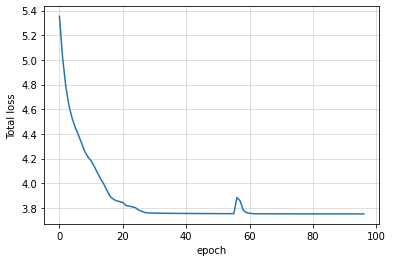

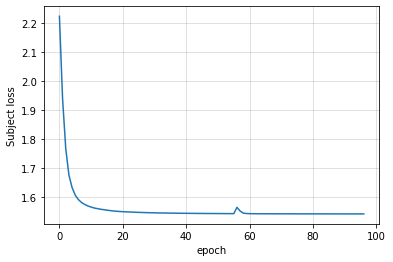

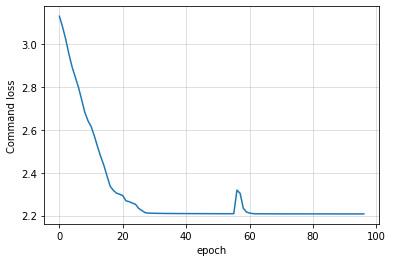

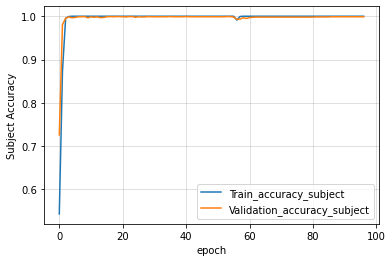

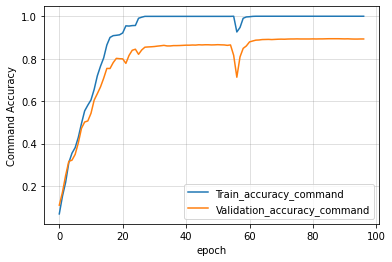

In [34]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['comd'])
plt.ylabel('Command loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
plt.ylabel('Command Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

In [35]:
for s in range(1,12):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 0.913
Subject # 2 : test Command Accuracy: 0.8957
Subject # 3 : test Command Accuracy: 0.9304
Subject # 4 : test Command Accuracy: 0.9174
Subject # 5 : test Command Accuracy: 0.9261
Subject # 6 : test Command Accuracy: 0.9261
Subject # 7 : test Command Accuracy: 0.9696
Subject # 8 : test Command Accuracy: 0.9391
Subject # 9 : test Command Accuracy: 0.8696
Subject # 10 : test Command Accuracy: 0.8261
Subject # 11 : test Command Accuracy: 0.7696


In [36]:
Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_7Image_unfreeze_0414.csv",index=False)

In [37]:
del best_model